In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

Using TensorFlow backend.


In [2]:
# https://www.kaggle.com/moltean/fruits
# train_path = '../fruits_data/fruits-360/Training'
# valid_path = '../fruits_data/fruits-360/Validation'
train_path = '../fruits_data/fruits-360-small/Training'
valid_path = '../fruits_data/fruits-360-small/Validation'

In [3]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
# useful for getting number of classes
folders = glob(train_path + '/*')

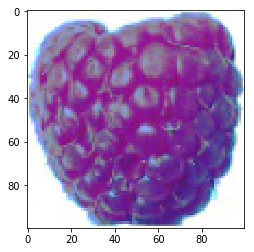

In [4]:
# sample image
plt.imshow(image.load_img(np.random.choice(image_files)))

In [5]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=[100, 100, 3], weights='imagenet', include_top=False)

In [6]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [7]:
# our layers 
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu)(x)
output = Dense(len(folders), activation='softmax')(x)

In [8]:
# create a model object
model = Model(inputs=vgg.input, outputs=output)

In [9]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

In [12]:
# test generator to see how it works and some other useful things
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=[100, 100])
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 1289 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -103.292725 max: 151.061


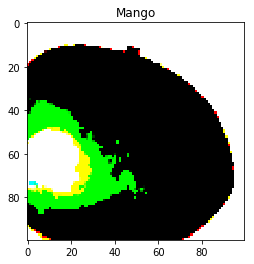

In [13]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    break

In [14]:
# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=[100, 100],
    shuffle=True,
    batch_size=32
)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    valid_path,
    target_size=[100, 100],
    shuffle=True,
    batch_size=32
)

Found 3839 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.


In [15]:
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=12,
    steps_per_epoch=int(np.floor(len(image_files) / 32)),
    validation_steps=int(np.floor(len(valid_image_files) / 32))
)

Epoch 1/12
119/119 [==============================] - 9s 78ms/step - loss: 2.7759 - acc: 0.8109 - val_loss: 2.0693 - val_acc: 0.8695
Epoch 2/12
119/119 [==============================] - 8s 67ms/step - loss: 2.0905 - acc: 0.8684 - val_loss: 2.1031 - val_acc: 0.8695
Epoch 3/12
119/119 [==============================] - 8s 70ms/step - loss: 2.0490 - acc: 0.8729 - val_loss: 2.0132 - val_acc: 0.8751
Epoch 4/12
119/119 [==============================] - 8s 71ms/step - loss: 2.0915 - acc: 0.8694 - val_loss: 2.1927 - val_acc: 0.8640
Epoch 5/12
119/119 [==============================] - 8s 69ms/step - loss: 2.0500 - acc: 0.8716 - val_loss: 2.0388 - val_acc: 0.8735
Epoch 6/12
119/119 [==============================] - 9s 72ms/step - loss: 2.0826 - acc: 0.8692 - val_loss: 2.0003 - val_acc: 0.8759
Epoch 7/12
119/119 [==============================] - 8s 69ms/step - loss: 2.0812 - acc: 0.8700 - val_loss: 2.1021 - val_acc: 0.8663
Epoch 8/12
119/119 [==============================] - 8s 69ms/step - 

In [16]:
def get_confusion_matrix(data_path, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(data_path, target_size=[100, 100], shuffle=False, batch_size=32 * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 3839
Found 3839 images belonging to 8 classes.
50
[[492   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0 490   0   0   0   0   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Generating confusion matrix 1289
Found 1289 images belonging to 8 classes.
[[164   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0 166   0   0   0   0   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


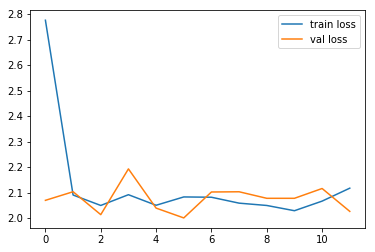

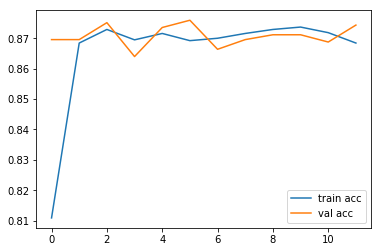

Confusion matrix, without normalization
[[492   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0 490   0   0   0   0   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Confusion matrix, without normalization
[[164   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0 166   0   0   0   0   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


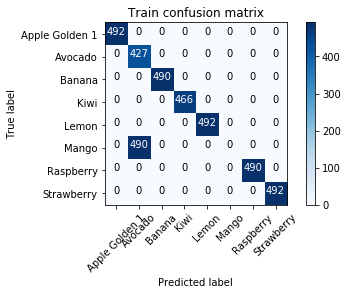

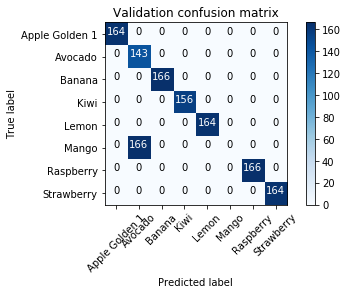

In [17]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

